# Libraries

In [1]:
import pandas as pd

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import seaborn as sns
import arviz as az

/home/tousside/Documents/AIMS/Courses/BayesianModellingDGSE/project/bayesian-epidemiology-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import numpyro
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from numpyro.diagnostics import hpdi


# Data

In [3]:
# path to CSV file ioth data
csv_file = "influenza-england-1978-school.csv"

data = pd.read_csv(csv_file)
data = data.rename(columns={'Unnamed: 0': 't'})
data.head()

,csvbase_row_id,date,in_bed,convalescent
0,1,1978-01-22,3,0
1,2,1978-01-23,8,0
2,3,1978-01-24,26,0
3,4,1978-01-25,76,0
4,5,1978-01-26,225,9


# Visualize the data

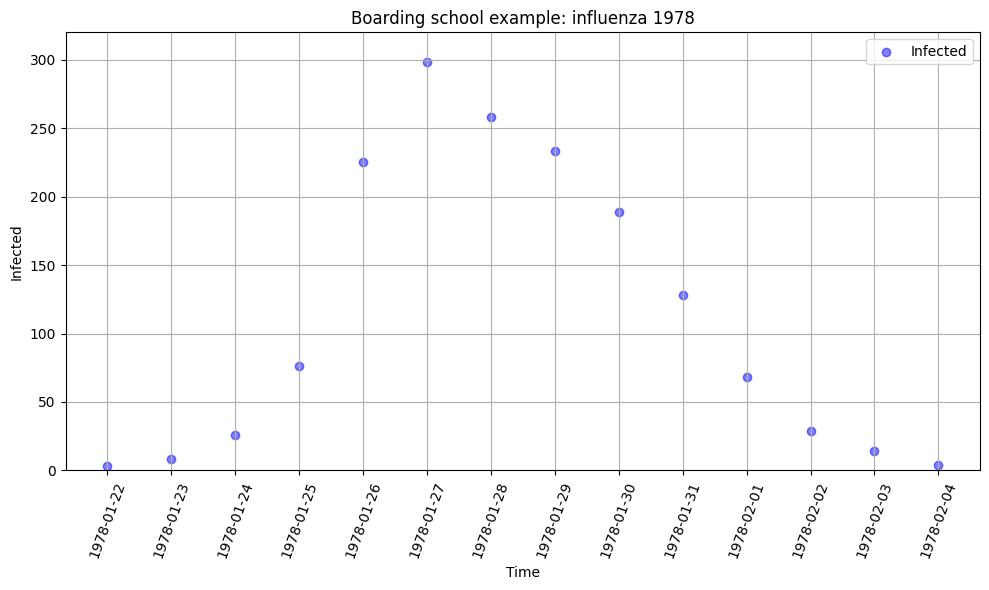

In [4]:
plt.figure(figsize=(10, 6))  

# plot 'in_bed' against 'date'
plt.scatter(data['date'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 320)
plt.title('Boarding school example: influenza 1978')

plt.xticks(rotation=70)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#

# Implemente the model: SIR

In [16]:
def SIR(observed_data=None, pop_size=None,  z_init=None, n_states=3):
    """
    Susceptible-Infectious (SIR) model.

    beta: infection rate (transmission rate).
    gamma: recovered rate.

    S, I : arrays representing the number of susceptible and infected individuals
           at each time step.
    """

    def dz_dt(z, t):
        S = z[0]
        I = z[1]
        R = z[2]

        dS_dt = -beta * I * S / pop_size
        dI_dt =  beta * I * S / pop_size - gamma*I
        dR_dt =  gamma * I

        return jnp.stack([dS_dt, dI_dt, dR_dt])

    if z_init is None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))
        
    
    # prior for beta
    beta = numpyro.sample('beta',dist.TruncatedNormal(loc=2, scale=1, low=0.))
    gamma = numpyro.sample('gamma',dist.TruncatedNormal(loc=0.4, scale=0.5, low=0.))
    
    R0 = numpyro.deterministic("R0", beta / gamma)
    
    recovery_time = numpyro.deterministic("recovery_time", 1 / gamma)
        
    #Negative binomial params
    phi_inv = numpyro.sample('phi',dist.Exponential(5))
    phi = 1/phi_inv
    # integrate dz/dt, the result will have shape num_days x 2
    time = jnp.arange(len(observed_data))*1.0
    
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, time, rtol=1e-6, atol=1e-5, mxstep=1000))

    # likelihood
    obs = numpyro.sample("observed", dist.NegativeBinomial2(z[:, 1], phi), obs=observed_data)
 

In [21]:
   
# observed data
observed_data = jnp.array(data['in_bed'])

# inference
nuts_kernel = NUTS(SIR)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)
#Initial condition
init = jnp.array([762.0, 1.0, 0.0])

mcmc.run(jax.random.PRNGKey(0), pop_size=763,  observed_data=observed_data, z_init=init)


/tmp/ipykernel_15804/331921430.py:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=4, progress_bar=True)
sample: 100%|██████████| 2000/2000 [00:02<00:00, 698.72it/s, 3 steps of size 5.83e-01. acc. prob=0.91]


# Checking the inference

In [22]:
mcmc.print_summary(exclude_deterministic=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.06      0.07      2.05      1.94      2.17   2030.18      1.00
     gamma      0.51      0.04      0.51      0.45      0.57   2323.20      1.00
       phi      0.11      0.07      0.09      0.02      0.21   2105.14      1.00

Number of divergences: 0


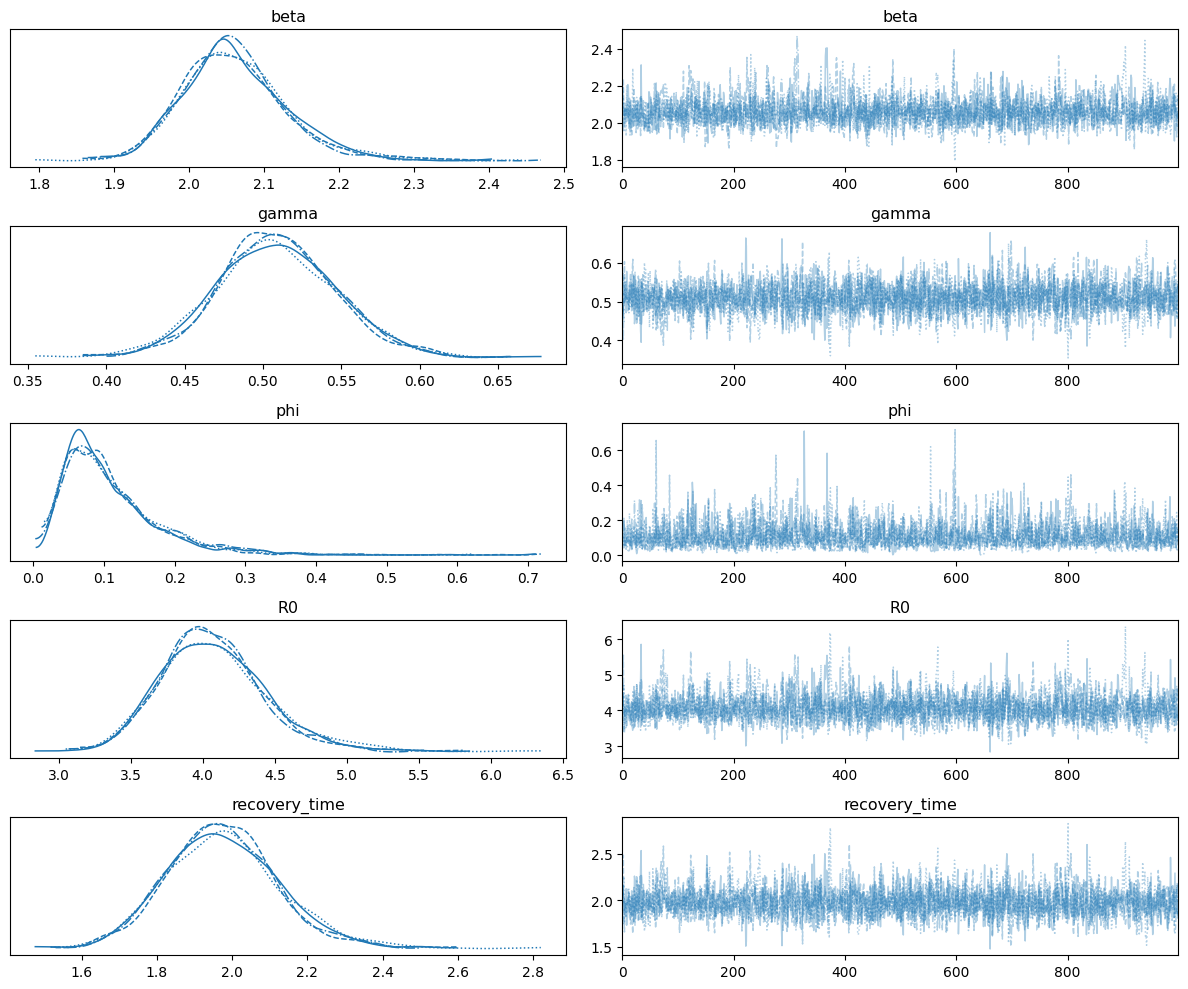

In [23]:
inf_data = az.from_numpyro(mcmc)
az.plot_trace(inf_data, compact=True, var_names=["beta", "gamma", "phi", "R0", "recovery_time"]);
plt.tight_layout()

The different chains agree with each other 

# Checking the model prediction 

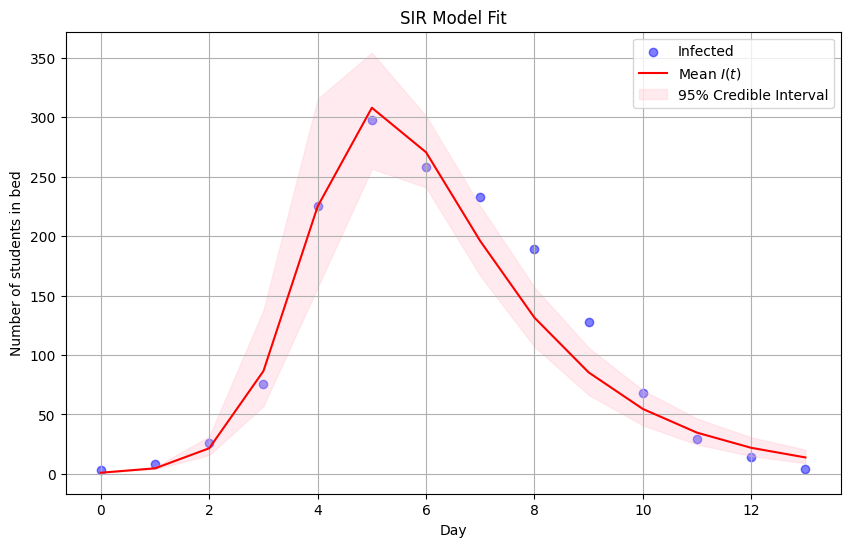

In [28]:
# extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(jnp.arange(len(data['date'])), data['in_bed'], color='blue', alpha=0.5, label='Infected')

# plot median of the posterior distribution
plt.plot(jnp.arange(len(data['date'])), mean_infected, color='red', label='Mean $I(t)$')

# plot uncertainty bounds
plt.fill_between(jnp.arange(len(data['date'])), lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Day')
plt.ylabel('Number of students in bed')
plt.title('SIR Model Fit')
plt.legend()
plt.grid(True)
plt.show()

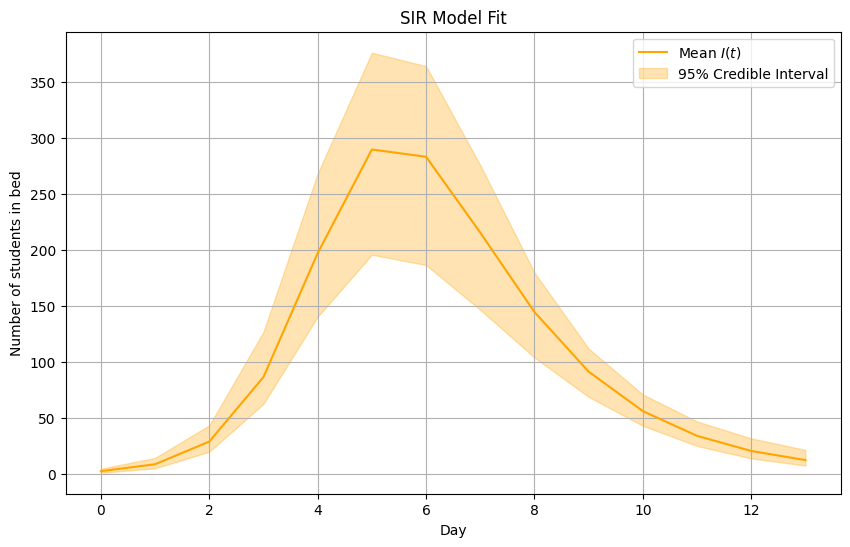

In [11]:
# extract posterior samples
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples['z']

# calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samples, 2.5, axis=0)[:, 1]
upper_bound_infected = jnp.percentile(z_samples, 97.5, axis=0)[:, 1]
mean_infected        = jnp.mean(z_samples, axis=0)[:, 1]

# plot the observed data
plt.figure(figsize=(10, 6))
# plt.scatter(data['date'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# plot median of the posterior distribution
plt.plot(jnp.arange(len(data['date'])), mean_infected, color='orange', label='Mean $I(t)$')

# plot uncertainty bounds
plt.fill_between(jnp.arange(len(data['date'])), lower_bound_infected, upper_bound_infected, color='orange', alpha=0.3, label='95% Credible Interval')

plt.xlabel('Day')
plt.ylabel('Number of students in bed')
plt.title('SIR Model Fit')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True)
plt.show()

# 2 Using simulated data to understand our model

## prior predictive for the basic reproduction number and recovery time

In [103]:
rng_key = jax.random.PRNGKey(0)
prior_predictive = Predictive(SIR, num_samples=1000)
prior_predictions = prior_predictive(rng_key, observed_data=observed_data, pop_size=763)


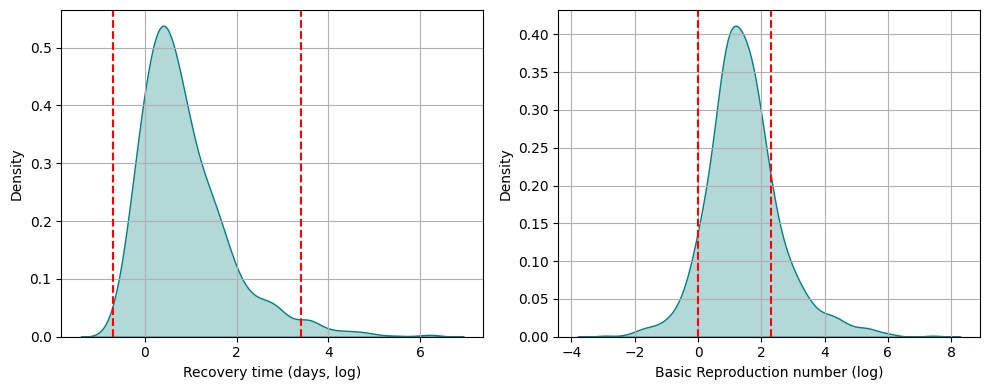

In [93]:
recovery_time = prior_predictions['recovery_time']
reproduction_number = prior_predictions['R0']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(jnp.log(recovery_time), alpha=0.3, color='teal', fill = True)
plt.axvline(jnp.log(0.5), color="red", linestyle="--")
plt.axvline(jnp.log(30), color="red", linestyle="--")
plt.xlabel("Recovery time (days, log)")

plt.grid(0.3)

plt.subplot(1, 2, 2)
sns.kdeplot(jnp.log(reproduction_number), alpha=0.3, color='teal', fill = True)
plt.xlabel('Basic Reproduction number (log)')
plt.axvline(jnp.log(1), color="red", linestyle="--")
plt.axvline(jnp.log(10), color="red", linestyle="--")
plt.grid(0.3)
plt.tight_layout()
plt.show()


## Infected students prior prediction

In [104]:
prior_predictions.keys()

dict_keys(['R0', 'beta', 'gamma', 'observed', 'phi', 'recovery_time', 'z', 'z_init'])

In [105]:
prior_infected_students = prior_predictions["z"]

Text(0, 0.5, 'Number of infected students')

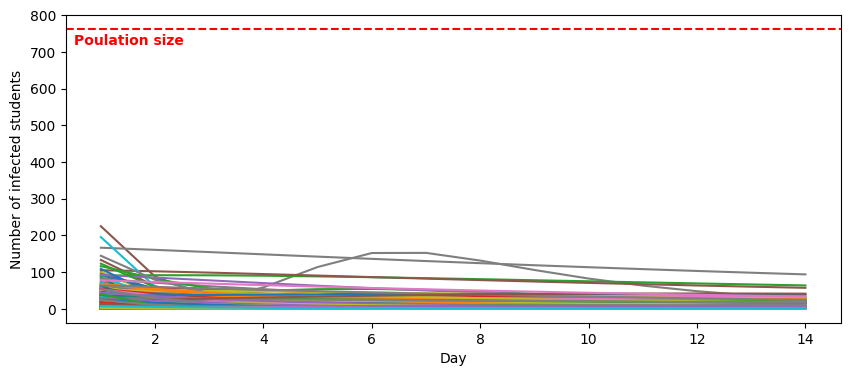

In [124]:
fig, ax= plt.subplots(figsize=(10, 4))

for i in range(1000):
    ax.plot(jnp.arange(1,15),prior_infected_students[i,:,1])
plt.axhline(763, color="red", linestyle="--")
plt.text(0.5, 720, "Poulation size", color="red", fontweight="bold")
plt.xlabel("Day")
plt.ylabel("Number of infected students")